In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats, optimize

In [2]:
df = pd.read_csv('data/wholetime.csv')
df = df.dropna()

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4227/488756067.py:1: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/wholetime.csv')


In [3]:
# dfを分割する
# データセットをいくつかのグループに分ける
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [6]:
# Get the node_list, edge_list and timestamp
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [7]:
node_list_p1, edge_list_p1, timestamp_p1 = return_nm(df_p1)
node_list_p2, edge_list_p2, timestamp_p2 = return_nm(df_p2)
node_list_p3, edge_list_p3, timestamp_p3 = return_nm(df_p3)
node_list_p4, edge_list_p4, timestamp_p4 = return_nm(df_p4)

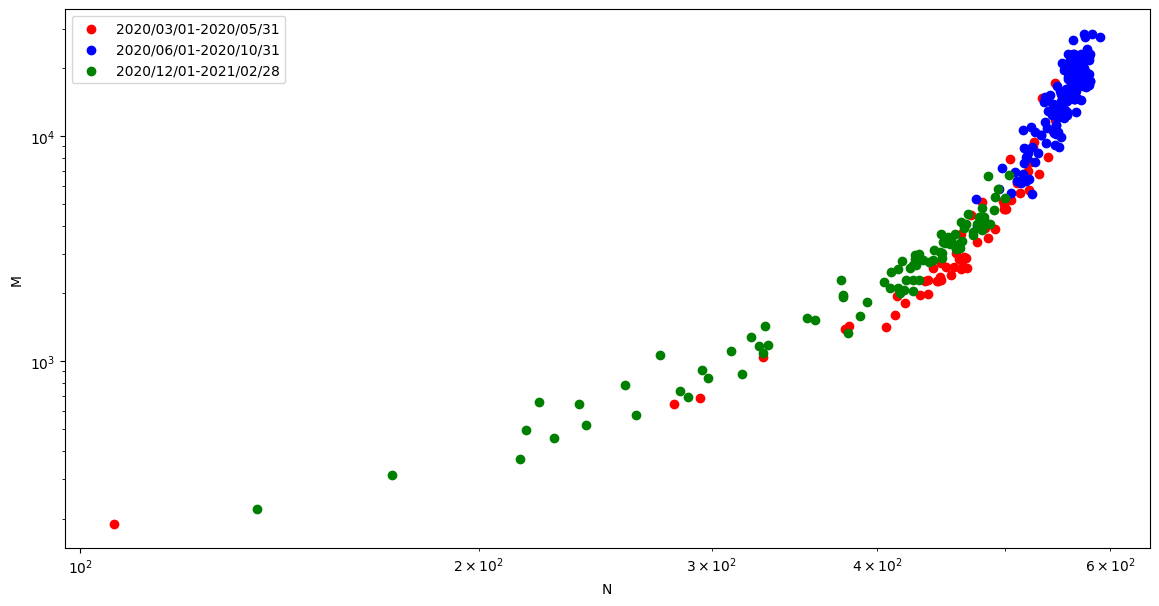

In [8]:
color_list = ['red', 'blue', 'green', 'orange']

plt.figure(figsize=(14, 7))
plt.scatter(node_list_p1, edge_list_p1, label='2020/03/01-2020/05/31', color=color_list[0])
plt.scatter(node_list_p2, edge_list_p2, label='2020/06/01-2020/10/31', color=color_list[1])
plt.scatter(node_list_p3, edge_list_p3, label='2020/12/01-2021/02/28', color=color_list[2])
# plt.scatter(node_list_p4, edge_list_p4, label='2021/03/01-2023/9/30', color=color_list[3])
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [9]:
node_left, edge_left, timestamp_left = return_nm(df_left)
node_right, edge_right, timestamp_right = return_nm(df_right)

In [10]:
"""
Kobayashi & Génois (2021)のモデルを用いて、計算する
"""
def model1(m, m0, kappa):
    Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2
    res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
    if res.any() < 0:
        return 0
    else:
        return res
    
def model2(m, m0, Np):
    kappa = 8*m0/(Np**2-Np)
    res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))
    if res.any() < 0:
        return 0
    else:
        return res
    
def calc_N(Np, kappa):
    return Np * (1 - (2 / (kappa * Np))*(1 - (1 - (kappa / 2))**Np))

def calc_M(Np, kappa):
    return (kappa * Np * (Np - 1)) / 8

In [11]:
print(len(node_left))

608


In [59]:
# 赤と青をそれぞれのモデルでフィッティングする
"""model1
推定する
赤バージョン
"""
init_m0_range = [1, 600]
init_kappa_range = [0.01, 1.05]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(1000):
    init_m0 = np.random.uniform(*init_m0_range)
    init_kappa = np.random.uniform(*init_kappa_range)
    

    popt, pcov = optimize.curve_fit(model1, edge_left, node_left, p0=[init_m0, init_kappa])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_left - model1(edge_left, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
m0_init = best_fit[0]
kappa_init = best_fit[1]

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4227/4113075532.py:6: RuntimeWarning: invalid value encountered in scalar power
  res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4227/4113075532.py:5: RuntimeWarning: invalid value encountered in sqrt
  Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2


[6.55918631e+04 1.93504762e+00]


In [60]:
"""model2
推定する
"""
# 初期値を探す for model2
# 初期値の範囲を設
init_m0_range = [1, 10000]
init_Np_range = [1, 2000]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range)
    init_Np = np.random.uniform(*init_Np_range)
    

    popt, pcov = optimize.curve_fit(model2, edge_left, node_left, p0=[init_m0, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_left - model2(edge_left, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

[474.76817371 882.36733083]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4227/4113075532.py:14: RuntimeWarning: invalid value encountered in scalar power
  res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4227/4113075532.py:14: RuntimeWarning: overflow encountered in scalar power
  res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))


In [61]:
N_fit = []
M_fit = []
popt, pcov = optimize.curve_fit(model1,edge_left,node_left,p0=[m0_init, kappa_init])
print("model1: ", popt)

Np = []
kappa = popt[1]
for i in range(len(edge_left)):
    Np.append((1+np.sqrt(1+32*edge_left[i]/kappa))/2)


for i in range(len(node_left)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(edge_left)):
    M_fit.append(calc_M(Np[i], kappa))

model1:  [6.55918631e+04 1.93504762e+00]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4227/4113075532.py:6: RuntimeWarning: overflow encountered in scalar power
  res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4227/4113075532.py:5: RuntimeWarning: invalid value encountered in sqrt
  Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2


In [62]:
N_fit2 = []
M_fit2 = []
popt2, pcov2 = optimize.curve_fit(model2, edge_left, node_left, p0=[m0_init2, Np_init2])
print("model2: ", popt2)
Np2 = popt2[1]
kappa2 = []
for i in range(len(edge_left)):
    kappa2.append(8*edge_left[i]/(Np2**2-Np2))

for i in range(len(node_left)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(edge_left)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

model2:  [474.76817371 882.36733083]


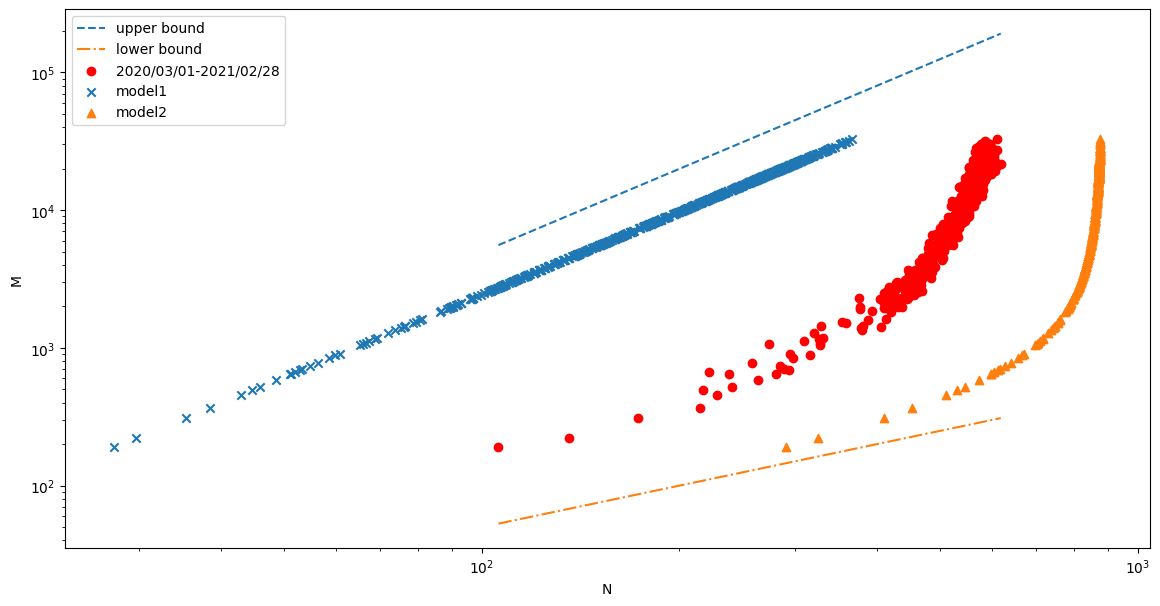

In [63]:
# plot
nn = len(node_left)
xmin = min(node_left)
xmax = max(node_left)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2
kappa = 8.20111280e-02
Np = 4999.63211846

plt.figure(figsize=(14, 7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.scatter(node_left, edge_left, label='2020/03/01-2021/02/28', color=color_list[0])
#plt.text(0.5, 0.5, r"$\hat{\kappa} = {:.8f}$".format(kappa), transform=plt.gca().transAxes, fontsize=14)
#plt.text(0.7, 0.7, r"$\hat{N_{p}} = {:.8f}$".format(Np), transform=plt.gca().transAxes, fontsize=14)
plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
# plt.scatter(node_right, edge_right, label='2021/03/01-2023/9/30', color=color_list[1])
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [40]:
# 赤と青をそれぞれのモデルでフィッティングする
"""model1
推定する
赤バージョン
"""
init_m0_range = [1, 300]
init_kappa_range = [0.01, 1.05]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(1000):
    init_m0 = np.random.uniform(*init_m0_range)
    init_kappa = np.random.uniform(*init_kappa_range)
    

    popt, pcov = optimize.curve_fit(model1, edge_right, node_right, p0=[init_m0, init_kappa])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_right - model1(edge_right, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
m0_init = best_fit[0]
kappa_init = best_fit[1]

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3333/4113075532.py:6: RuntimeWarning: invalid value encountered in scalar power
  res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3333/4113075532.py:5: RuntimeWarning: invalid value encountered in sqrt
  Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2


[6.62819199e+03 1.39174297e-01]


In [41]:
"""model2
推定する
"""
# 初期値を探す for model2
# 初期値の範囲を設定
init_m0_range = [1, 40000]
init_Np_range = [1, 10000]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(1000):
    init_m0 = np.random.uniform(*init_m0_range)
    init_Np = np.random.uniform(*init_Np_range)
    

    popt, pcov = optimize.curve_fit(model2, edge_right, node_right, p0=[init_m0, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_right - model2(edge_right, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3333/4113075532.py:14: RuntimeWarning: invalid value encountered in scalar power
  res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3333/4113075532.py:14: RuntimeWarning: overflow encountered in scalar power
  res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3333/4113075532.py:14: RuntimeWarning: overflow encountered in scalar multiply
  res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))


[ 325.17557933 5673.60461538]


In [42]:
N_fit = []
M_fit = []
popt, pcov = optimize.curve_fit(model1,edge_left,node_left,p0=[m0_init, kappa_init])
print("model1: ", popt)

Np = []
kappa = popt[1]
for i in range(len(edge_left)):
    Np.append((1+np.sqrt(1+32*edge_left[i]/kappa))/2)


for i in range(len(node_left)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(edge_left)):
    M_fit.append(calc_M(Np[i], kappa))

model1:  [6.53288938e+03 1.85720313e-01]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3333/4113075532.py:6: RuntimeWarning: overflow encountered in scalar power
  res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )


In [43]:
N_fit2 = []
M_fit2 = []
popt2, pcov2 = optimize.curve_fit(model2, edge_left, node_left, p0=[m0_init2, Np_init2])
print("model2: ", popt2)
Np2 = popt2[1]
kappa2 = []
for i in range(len(edge_left)):
    kappa2.append(8*edge_left[i]/(Np2**2-Np2))

for i in range(len(node_left)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(edge_left)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

model2:  [ 300.25412745 2686.26997321]


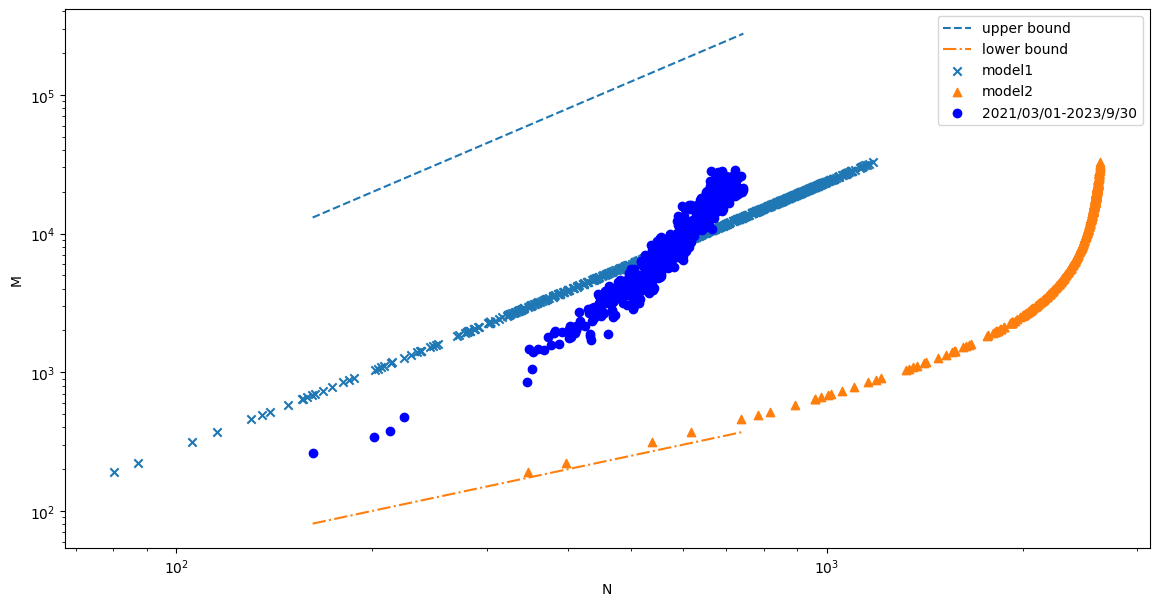

In [44]:
# plot
nn = len(node_right)
xmin = min(node_right)
xmax = max(node_right)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14, 7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
# plt.scatter(node_left, edge_left, label='2020/03/01-2021/02/28', color=color_list[0])
plt.scatter(node_right, edge_right, label='2021/03/01-2023/9/30', color=color_list[1])
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()